# Итоговый проект "Телекоммуникации".

## Загрузка данных.

**Импортируем необходимые библиотеки.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from skimpy import clean_columns
except:
    !pip install skimpy
    from skimpy import clean_columns
    
import numpy as np

try:
    import phik
except:
    !pip install phik
    import phik
    
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, 
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix

try:
    import shap
except:
    !pip install shap
    import shap

**Инициализируем все константы, которые будем использовать в работе.**

In [2]:
RANDOM_STATE = 20924
TEST_SIZE = 0.25

**Создадим необходимые функции:**

1. Data_load - функция загрузки данных.
2. Data_merge - функция объединения датафреймов.
3. Data_info - функция вывода общей информации о датафрейме.
4. Data_graf_num - функция вывода графиков для исследовательского анализа численных признаков.
5. Data_graf_cat - функция вывода графиков для исследовательского анализа категориальных признаков.
6. Fit_pred - функция для обучения модели.

In [3]:
def data_load(path):
    """
    Загружает данные формата .csv.

    Параметры:
    path (string): Путь к файлам.

    Возвращает:
    pd.DataFrame: Загруженные датасеты.
    """
    
    contract = pd.read_csv(path + 'contract_new.csv')
    personal = pd.read_csv(path + 'personal_new.csv')
    internet = pd.read_csv(path + 'internet_new.csv')
    phone = pd.read_csv(path + 'phone_new.csv')
    return contract, personal, internet, phone

In [4]:
def data_merge(data1, data2):
    """
    Объединяет датафреймы в один по общему столбцу.

    Параметры:
    data1 (pd.DataFrame): Первый датасет.
    data2 (pd.DataFrame): Второй датасет.

    Возвращает:
    pd.DataFrame: Итоговый датасет.
    """
    
    data_new = pd.merge(
        data1, data2,
        left_on='customerID',
        right_on='customerID',
        how='outer')
    
    return data_new

In [5]:
def data_info(data):
    """
    Выводит общую информацию о датафрейме.

    Параметры:
    data (pd.DataFrame): Датасет.
    """
    
    print('Первые пять строк датафрема:\n')
    print(data.head())
    print('Информация о датафрейме:\n')
    print(data.info())
    print('\nОписание датафрейма:\n')
    print(data.describe())
    print('\nКоличество пропусков:')
    print(data.isna().sum())
    print('\nКоличество дубликатов:', data.duplicated().sum())
    print(data[data.duplicated()])
    object_columns = data.select_dtypes(include=["object"]).columns.tolist()
    print('\nПроверка на неявные дубликаты:')
    for col in object_columns:
        print(col, ': ', data[col].unique())

In [6]:
def data_graf_num(data):
    """
    Выводит графики для исследовательского анализа численных признаков.

    Параметры:
    data (pd.DataFrame): Датасет.
    """
    
    numeric_columns = data.select_dtypes(include=["int", "float"]).columns.tolist()
    for col in numeric_columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.histplot(ax=axes[0], x=data[col], bins = 50)
        axes[0].set_title(data[col].name)
        sns.boxplot(ax=axes[1], x=data[col])
        axes[1].set_title(data[col].name)
        plt.show()

In [7]:
def data_graf_cat(data):
    """
    Выводит графики для исследовательского анализа категориальных признаков.

    Параметры:
    data (pd.DataFrame): Датасет.
    """
    categorical_columns = data.select_dtypes(include=["object"]).columns.tolist()
    categorical_columns.remove('customerID')
    num_plots = len(categorical_columns)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))

    if num_plots == 1:
        axes = [axes]
    
    for i, col in enumerate(categorical_columns):
        data.groupby(col)['customerID'].count().plot(ax=axes[i], kind='bar')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()          

In [8]:
def fit_pred(X_train, y_train, X_test, pipe_final, param_grid):
    """
    Обучает собранный пайплайн и выводит на экран лучшую модель, ее параметры и метрику на тренировочной выборке.

    Параметры:
    X_train (pd.DataFrame): Признаки тренировочной выборки.
    y_train (pd.Series): Целевая переменная тренировочной выборки.
    X_test (pd.DataFrame): Признаки тестовой выборки.
    pipe_final (sklearn.pipeline.Pipeline): Пайплайн модели.
    param_grid (dict): Параметры модели для перебора.
    """
    
    randomized_search = RandomizedSearchCV(
        pipe_final, 
        param_grid,
        cv=5,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        error_score='raise'
    )
    randomized_search.fit(X_train, y_train)

    print('Лучшая модель:\n\n', randomized_search.best_estimator_)
    print('\nПараметры лучшей модели:\n\n', randomized_search.best_params_)
    print('\nМетрика лучшей модели на тренировочной выборке:', abs(randomized_search.best_score_))

**Загрузим все данные и получим четыре датафрейма.**

In [9]:
try:
    path = '/datasets/'
    contract, personal, internet, phone = data_load(path)
except:
    path = 'C:/Users/Mariya/Desktop/'
    contract, personal, internet, phone = data_load(path)

## Объединение данных

**Объединим четыре датафрейма в один по ключу.**

In [10]:
contr_pers = data_merge(contract, personal)
contr_pers_intern = data_merge(contr_pers, internet)
data = data_merge(contr_pers_intern, phone)

**Рассмотрим все датафреймы по отдельности и выведем на экран главную информацию.**

In [11]:
data_info(data)

Первые пять строк датафрема:

   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  gender  \
0           Electronic check           29.85        31.04  Female   
1               Mailed check           56.95      2071.84    Male   
2               Mailed check           53.85       226.17    Male   
3  Bank transfer (automatic)           42.30       1960.6    Male   
4           Electronic check           70.70        353.5  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0              0     Yes         No             DSL             

**Отдельно выведем рассмотрим уникальные значения столбцов customerID и TotalCharges.**

In [12]:
pd.Series(data['customerID'].unique()).sort_values()

2307    0002-ORFBO
3488    0003-MKNFE
3845    0004-TLHLJ
5931    0011-IGKFF
5569    0013-EXCHZ
           ...    
3607    9987-LUTYD
2875    9992-RRAMN
1260    9992-UJOEL
1996    9993-LHIEB
1634    9995-HOTOH
Length: 7043, dtype: object

In [13]:
pd.Series(data['TotalCharges'].unique()).sort_values()

485           
1258    100.17
3614    100.19
3094     100.2
1161    100.24
         ...  
4723    997.05
2805    997.78
3174    998.89
1667     999.6
1596     999.9
Length: 6658, dtype: object

**Рассмотрим распределения численных признаков.**

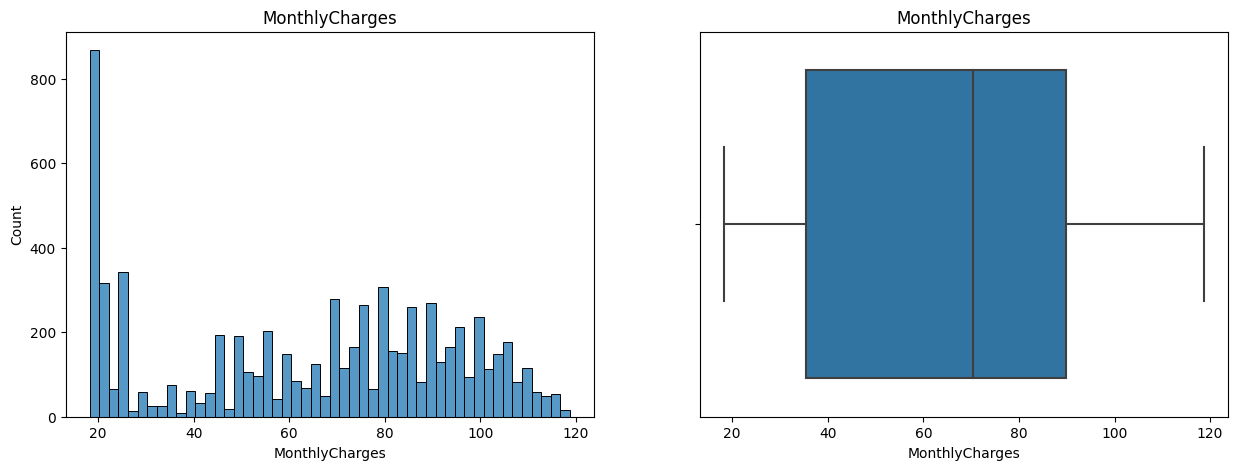

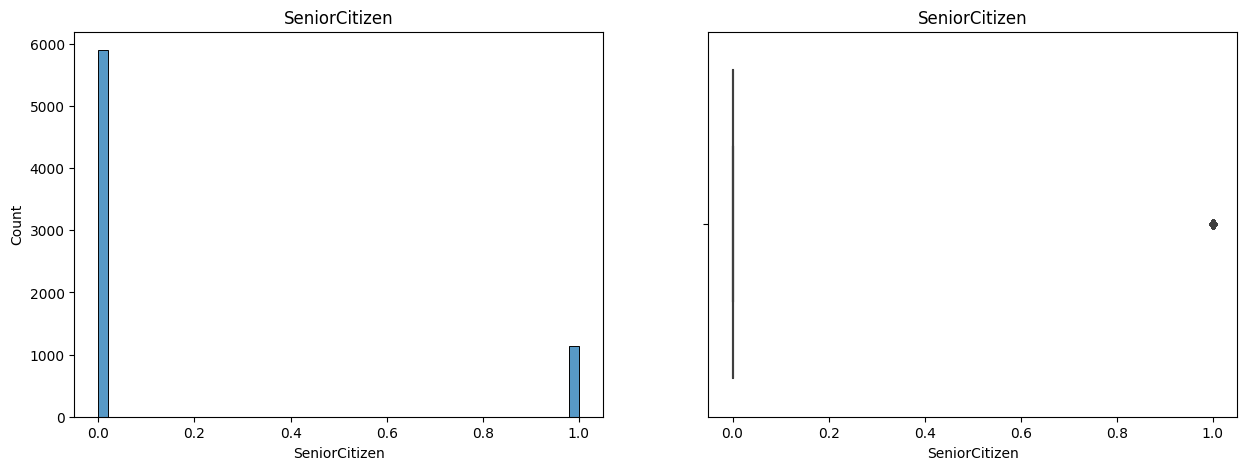

In [14]:
data_graf_num(data)

**Рассмотрим столбчатые диаграммы категориальных признаков.**

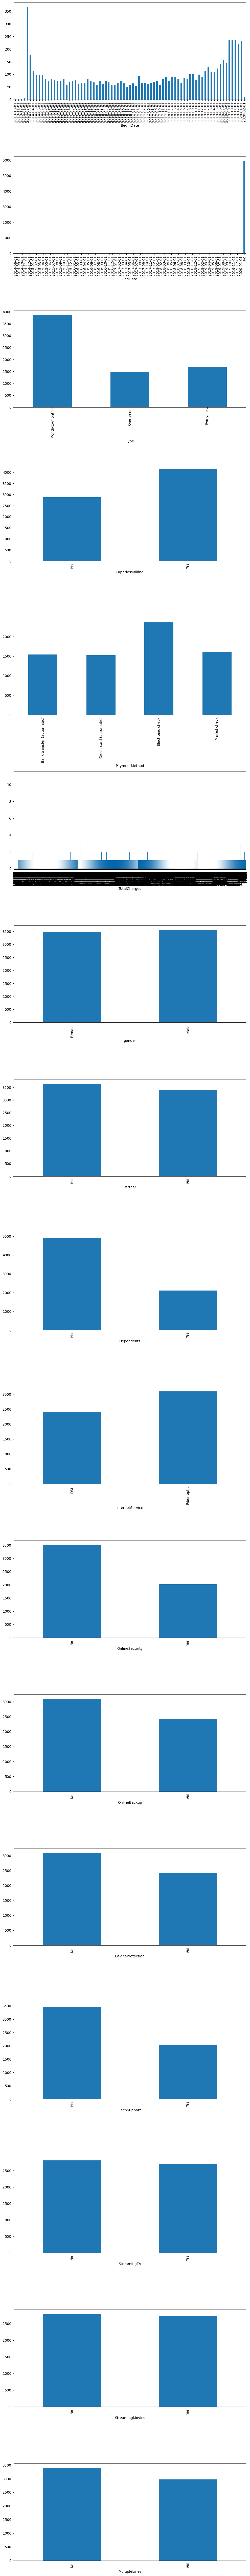

In [15]:
data_graf_cat(data)

**В ходе объединения данных мы заметили:**
- названия столбцов находятся не в стиле Snake Case;
- большое количество категориальных признаков;
- выбросы и аномалии в данных отсутствуют;
- при объединении столбцов образовалось большое количество пропусков;
- столбцы BeginDate, EndDate и TotalCharges имеет неверный тип данных и пробелы в значениях;
- признаки с датами дают очень мало информации.

**При предобработке данных нам необходимо:**
- перевести названия столбцов в стиль Snake Case;
- обработать пропуски в данных, включая пробелы;
- поменять типы данных столбцов: TotalCharges на вещественный тип, BeginDate и EndDate на тип даты и времени;
- создать целевую переменную;
- удалить ненужные признаки и добавить новые.

## Предобработка данных

**Запишем названия столбцов в стиле Snake Case.**

In [16]:
data = clean_columns(data)
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

**Избавимся от пробела в признаке total_charges. Так как вероятно абонент еще не имел расходов, заменим его на значение 0.**

In [17]:
data['total_charges'] = data['total_charges'].apply(lambda x: 0 if x == ' ' else x)
data['total_charges'].dtype

dtype('O')

**Теперь поменяем тип данных столбца total_charges на вещественный.**

In [18]:
data['total_charges'] = data['total_charges'].astype('float')
data['total_charges'].dtype

dtype('float64')

**Создадим целевой признак по столбцу end_date. Если клиент остался, обозначим это как 1, иначе 0.**

In [19]:
data['target'] = data['end_date'].apply(lambda x: 1 if x == 'No' else 0)
data[['end_date', 'target']].head()

,end_date,target
0,No,1
1,No,1
2,No,1
3,No,1
4,No,1


**Теперь поменяем тип данных столбцов begin_date и end_date на тип даты и времени. Для этого нужно сначала заменить в столбце end_date 'No' на последнюю дату.**

In [20]:
data['end_date'] = data['end_date'].apply(lambda x: '2020-02-01' if x == 'No' else x)

data['begin_date'] = data['begin_date'].astype("datetime64[ns]")
data['end_date'] = data['end_date'].astype("datetime64[ns]")

print(data['begin_date'].dtype, ', ', data['begin_date'].dtype)

datetime64[ns] ,  datetime64[ns]


**Теперь избавимся от всех пропусков в данных. Рассмотрим проценты пропущенных значений в столбцах.**

In [21]:
pd.DataFrame(round(data.isna().mean()*100))

,0
customer_id,0.0
begin_date,0.0
end_date,0.0
type,0.0
paperless_billing,0.0
payment_method,0.0
monthly_charges,0.0
total_charges,0.0
gender,0.0
senior_citizen,0.0


**Так как мы имеем пропуски в информации об интернет-услугах и об услугах телефонии, то вероятно, их у клиента не было. Данные категориальные, а значит, мы можем заменить все значения на 'No'.**

In [22]:
data = data.fillna('No')
pd.DataFrame(round(data.isna().mean()*100))

,0
customer_id,0.0
begin_date,0.0
end_date,0.0
type,0.0
paperless_billing,0.0
payment_method,0.0
monthly_charges,0.0
total_charges,0.0
gender,0.0
senior_citizen,0.0


**Уберем признаки begin_date и end_date. Они не дают нам никакой информации. Вместо них добавим признак продолжительности действия договора с клиентом (begin_date - end_date).**

In [23]:
data["days"] = (data["end_date"] - data["begin_date"]) / np.timedelta64 (1 , 'D')
data[['end_date', 'begin_date', 'days']].head()

,end_date,begin_date,days
0,2020-02-01,2020-01-01,31.0
1,2020-02-01,2017-04-01,1036.0
2,2020-02-01,2019-10-01,123.0
3,2020-02-01,2016-05-01,1371.0
4,2020-02-01,2019-09-01,153.0


In [24]:
data = data.drop(['end_date', 'begin_date'], axis=1)

**Рассмотрим матрицу корреляций признаков.**

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target', 'days']


<Axes: >

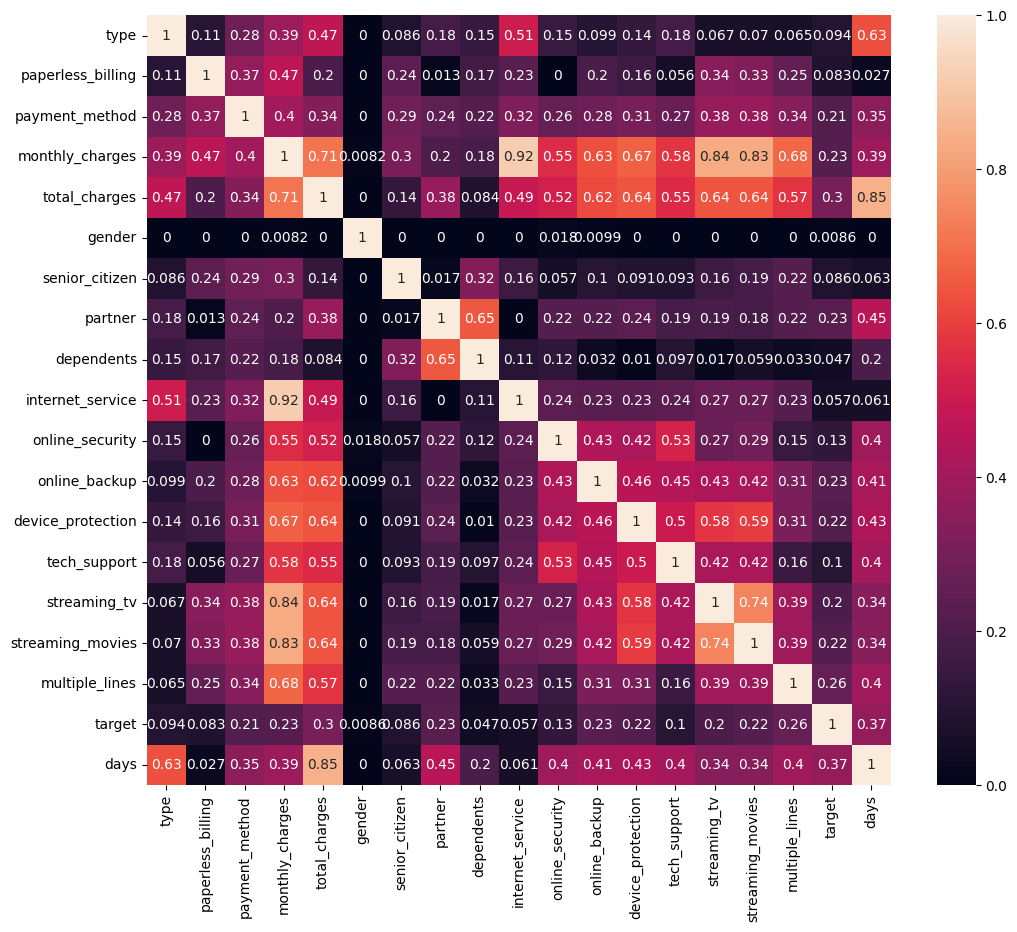

In [25]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.drop(['customer_id'], axis=1).phik_matrix(), annot=True)

**Дополнительно посчитаем VIF.**

In [26]:
column = data.select_dtypes(include=["int", "float"]).columns.tolist()
column.pop(0)
X = data[column].copy()
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data['columns'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,columns,VIF
0,const,8.556592
1,total_charges,3.168846
2,senior_citizen,1.027644
3,target,1.007070
4,days,3.134800


**VIF:**
- Значение 1 указывает на отсутствие корреляции между данной переменной-предиктором и любыми другими переменными-предикторами в модели.
- Значение от 1 до 5 указывает на умеренную корреляцию между данной переменной-предиктором и другими переменными-предикторами в модели, но часто она недостаточно серьезная, чтобы требовать внимания.
- Значение больше 5 указывает на потенциально сильную корреляцию между данной переменной-предиктором и другими переменными-предикторами в модели. В этом случае оценки коэффициентов и p-значения в выходных данных регрессии, вероятно, ненадежны.

Следовательно, мультиколлинеарность отсутствует или умеренна, все значения меньше пяти.

**Заметим, что столбцы gender и senior_citizen не имеют зависимости с другими признаками. А признаки dependents и internet_service имеют очень слабую корреляцию с целевым. Избавимся от них.**

In [27]:
data = data.drop(['gender', 'senior_citizen', 'dependents', 'internet_service'], axis=1)

**Снова выведем матрицу корреляций.**

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'days']


<Axes: >

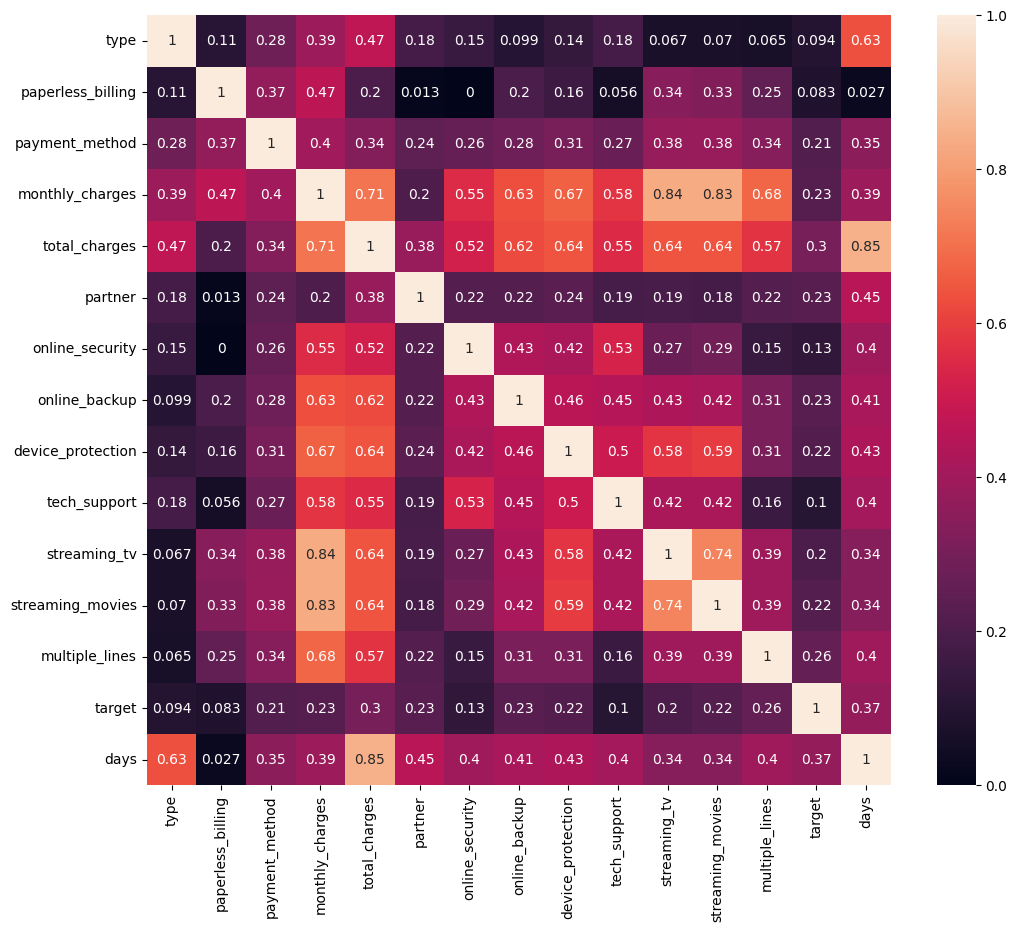

In [28]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.drop(['customer_id'], axis=1).phik_matrix(), annot=True)

**В ходе предобработки данных мы:**
- перевели названия столбцов в стиль Snake Case;
- обработали пропуски в данных, включая пробелы;
- поменяли типы данных столбцов: total_charges на вещественный тип, begin_date и end_date на тип даты и времени;
- создали целевую переменную target со значениями 0 (клиент ушел) и 1 (клиент остался);
- удалить ненужные признаки (begin_date, end_date, gender, senior_citizen, dependents, internet_service);
- добавили новый признак days (end_date - begin_date).

**Теперь нам необходимо:**
- разделить данные на обучающую и тестовую выборки;
- обозначить модели, которые мы будем обучать;
- относительно выбранных моделей принять решение о кодировании и масштабировании признаков.

## Разделение на выборки

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['target', 'customer_id'], axis=1),
    data['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['target'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((5282, 14), (1761, 14), (5282,), (1761,))

**Мы разделили данные на выборки, теперь необходимо определиться с моделями и перейти к кодированию и масштабированию признаков.**

## Кодирование и масштабирование

**Будем использовать три модели для обучения:**
1. LogisticRegression: кодируем категориальные признаки с помощью OneHotEncoder, масштабируем численные с помощью MinMaxScaler.
2. CatBoost: переводим категориальные данные в тип category, масштабирование не нужно.
3. LightGBM: будем использовать сырые данные.

**Мы будем собирать пайплайны для перебора параметров моделей, поэтому пропишем кодирование и масштабирование для каждого набора данных. Начнем с первого набора для LogisticRegression.**

In [30]:
ohe_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
num_columns = X_train.select_dtypes(include=["int", "float"]).columns.tolist()

data_preprocessor_lr = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Для CatBoost переведем категориальные данные в тип category.**

In [31]:
categorical_columns = X_train.select_dtypes(include=["object"]).columns.tolist()

X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
X_train_cat[categorical_columns] = X_train_cat[categorical_columns].astype('category')
X_test_cat[categorical_columns] = X_test_cat[categorical_columns].astype('category')

X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 3251 to 3858
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   category
 1   paperless_billing  5282 non-null   category
 2   payment_method     5282 non-null   category
 3   monthly_charges    5282 non-null   float64 
 4   total_charges      5282 non-null   float64 
 5   partner            5282 non-null   category
 6   online_security    5282 non-null   category
 7   online_backup      5282 non-null   category
 8   device_protection  5282 non-null   category
 9   tech_support       5282 non-null   category
 10  streaming_tv       5282 non-null   category
 11  streaming_movies   5282 non-null   category
 12  multiple_lines     5282 non-null   category
 13  days               5282 non-null   float64 
dtypes: category(11), float64(3)
memory usage: 223.2 KB


**В ходе кодирования и масштабирования данных подготовлены три набора данных для обучения трех разных моделей:**
1. LogisticRegression: закодированы категориальные признаки с помощью OneHotEncoder, масштабированы численные с помощью MinMaxScaler.
2. CatBoost: переводены категориальные данные в тип category, масштабирование не было реализовано.
3. LightGBM: сохранены чистые данные.

**При обучении моделей машинного обучения необходимо:**
- обучить три модели с перебором параметров;
- вывести наилучшие модели с метрикой ROC-AUC на тренировочных данных.

## Обучение моделей машинного обучения

**Начнем обучение с модели LogisticRegression.**

In [32]:
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor_lr),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', n_jobs=-1))
])

# словарь для модели LogisticRegression()
param_grid_lr = {
        'models__C': range(1, 15)
}

In [33]:
fit_pred(X_train, y_train, X_test, pipe_lr, param_grid_lr)

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'partner',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines']),
                                                 ('num', MinMaxScaler(),
                                   

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


**Обучим модель CatBoostClassifier.**

In [34]:
pipe_cb = Pipeline([
    ('models', CatBoostClassifier(random_state=RANDOM_STATE, cat_features=categorical_columns))
])

# словарь для модели CatBoostClassifier()
param_grid_cb = {
    'models__n_estimators': [100, 200, 500],
    'models__depth': [4, 6, 8],
    'models__learning_rate': [0.01, 0.05, 0.1]
}

In [35]:
fit_pred(X_train_cat, y_train, X_test_cat, pipe_cb, param_grid_cb)

0:	learn: 0.6217445	total: 186ms	remaining: 1m 32s
1:	learn: 0.5534014	total: 214ms	remaining: 53.3s
2:	learn: 0.5210020	total: 225ms	remaining: 37.3s
3:	learn: 0.4858809	total: 249ms	remaining: 30.9s
4:	learn: 0.4531729	total: 273ms	remaining: 27s
5:	learn: 0.4274383	total: 297ms	remaining: 24.5s
6:	learn: 0.4098768	total: 321ms	remaining: 22.6s
7:	learn: 0.3978582	total: 339ms	remaining: 20.8s
8:	learn: 0.3837989	total: 363ms	remaining: 19.8s
9:	learn: 0.3735987	total: 400ms	remaining: 19.6s
10:	learn: 0.3679407	total: 442ms	remaining: 19.6s
11:	learn: 0.3611354	total: 470ms	remaining: 19.1s
12:	learn: 0.3569963	total: 495ms	remaining: 18.6s
13:	learn: 0.3498850	total: 516ms	remaining: 17.9s
14:	learn: 0.3480087	total: 525ms	remaining: 17s
15:	learn: 0.3436385	total: 546ms	remaining: 16.5s
16:	learn: 0.3408972	total: 566ms	remaining: 16.1s
17:	learn: 0.3373187	total: 587ms	remaining: 15.7s
18:	learn: 0.3346773	total: 611ms	remaining: 15.5s
19:	learn: 0.3316571	total: 637ms	remaining:

**Теперь обучим модель LGBMClassifier, на сырых данных этого не удалось сделать, поэтому используем данные, созданные для модели CatBoostClassifier.**

In [36]:
pipe_lgbm = Pipeline([
    ('models', LGBMClassifier(random_state=RANDOM_STATE, cat_features=categorical_columns))
])

# словарь для модели LGBMClassifier()
param_grid_lgbm = {
    'models__n_estimators': [25, 50, 100, 200],
    'models__max_depth': range(2, 50),
    'models__num_leaves': range(2, 15),
    'models__learning_rate': [0.01, 0.05, 0.1]
}

In [37]:
fit_pred(X_train_cat, y_train, X_test_cat, pipe_lgbm, param_grid_lgbm)

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Info] Number of positive: 4456, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.843620 -> initscore=1.685412
[LightGBM] [Info] Start training from score 1.685412
Лучшая модель:

 Pipeline(steps=[('models',
                 LGBMClassifier(cat_features=['type', 'paperless_billing',
                                              'payment_method', 'partner',
                                              'online_security',
                                              'online_backup',
                     

**В ходе этапа обучения:**
- обучены три модели: LogisticRegression, CatBoostClassifier и LGBMClassifier;
- наилучшая метрика получена моделью CatBoostClassifier с параметрами models__n_estimators=500, models__learning_rate=0.1 и models__depth=6 с ROC-AUC=0.89.

**В ходе выбора наилучшей модели необходимо:**
- проверить метрику ROC-AUC на тестовых данных.

## Выбор лучшей модели

**Снова обучим данные на лучшей модели и посмотрим метрику на тестовых данных.**

In [38]:
best_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                                cat_features=categorical_columns, 
                                verbose=0, 
                                n_estimators=500, 
                                learning_rate=0.1,
                                depth=6)
best_model.fit(X_train_cat, y_train)

y_pred_proba = best_model.predict_proba(X_test_cat)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9218891471919736


**Получим на тестовых данных метрику ROC-AUC=0.89. Условие выполнено. Теперь перейдем к исследованию важности признаков лучшей модели.**

## Исследование важности признаков лучшей модели.

**Проанализируем важность признаков.**

<Axes: ylabel='Feature'>

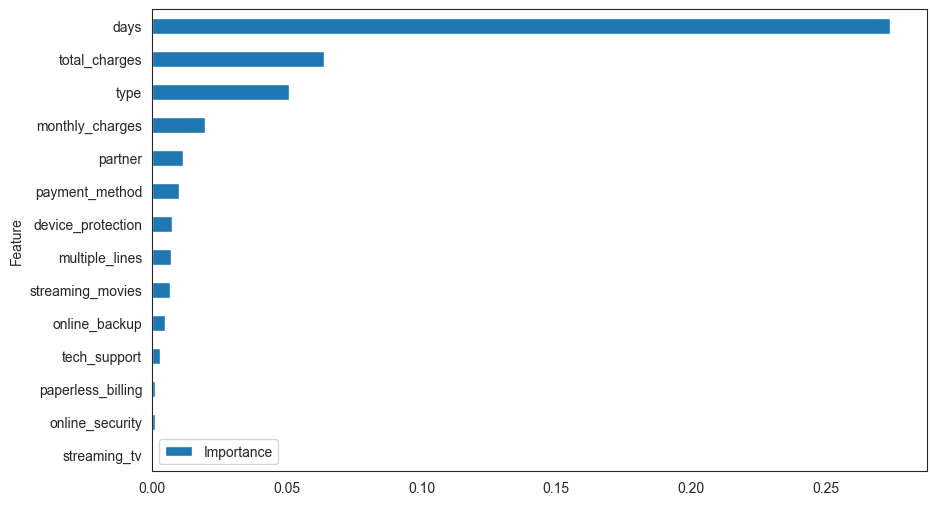

In [39]:
result = permutation_importance(best_model, X_test_cat, y_test, scoring='roc_auc', random_state=RANDOM_STATE)

feature_importance = pd.DataFrame({'Feature': X_test_cat.columns, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 

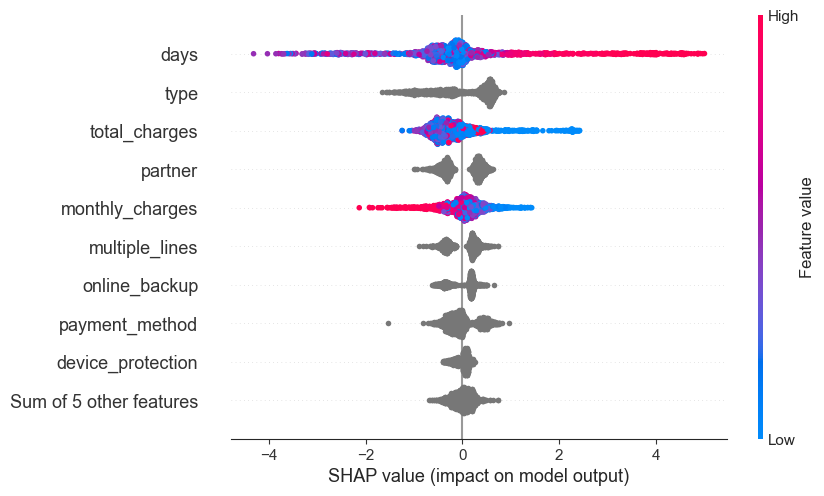

In [40]:
explainer = shap.TreeExplainer(best_model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test_cat)

shap.plots.beeswarm(shap_values)

1. Признаки, которые имеют отрицательные SHAP значения, увеличивают вероятность того, что клиент уйдет (целевой класс 0).
2. Признаки с положительными SHAP значениями увеличивают вероятность того, что клиент останется (целевой класс 1).

**Теперь выведем матрицу ошибок.**

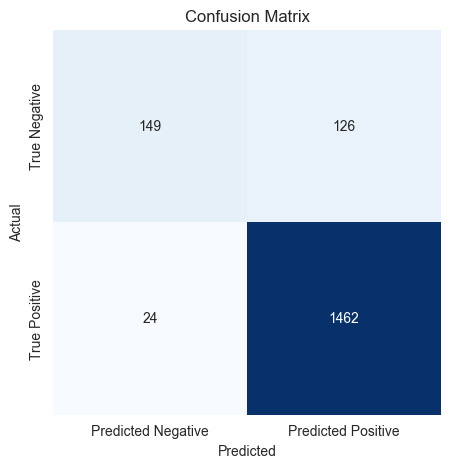

In [41]:
y_pred = best_model.predict(X_test_cat)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Модель хорошо справляется с предсказанием целевого класса 1, но не с предсказанием целевого класса 0.**

**В ходе исследования важности признаков лучшей модели было выявлено, что наибольшее влияние на целевой признак имеют признаки 'days', 'monthly_charges' и 'total_charges':**
- days: чем больше дней клиент остается с компанией, тем выше вероятность, что он останется;
- monthly_charges: высокие ежемесячные платежи увеличивают вероятность, что клиент останется;
- total_charges: чем больше клиент заплатил за все время, тем выше вероятность, что он останется.

## Общий вывод и рекомендации заказчику

**Итак, мы выполнили итоговый проект и можем сделать вывод по проделанной работе.**

1) Мы выполнили все пункты плана:

    1. Описание проекта: описали задачи, данные и план проекта.
    2. Загрузка данных: загрузили данные и выполнили их первичный осмотр.
    3. Объединение данных: объединили все датафреймы в один по ключу.
    4. Предобработка данных: выполнили исследовательский анализ объединённого датафрейма, визуализировали распределения признаков и выполнили предобработку, провели корреляционный анализ и сделали выводы об имеющихся признаках: понадобятся ли они для обучения моделей.
    5. Разделение на выборки: выполнили подготовку данных для обучения модели, разделили данные на две выборки.
    6. Кодирование и масштабирование: выполнили кодирование категориальных признаков с учетом используемых моделей и масштабирование количественных признаков.
    7. Обучение моделей машинного обучения: обучили две модели, подобрали к ним гиперпараметры, получили налучшую модель и ее метрику на кросс-валидации.
    8. Выбор лучшей модели: выбрали лучшую модель и проверили её качество на тестовой выборке.
    9. Исследование важности признаков лучшей модели: исследовали важность признаков и получили матрицу ошибок.
    10. Общий вывод и рекомендации заказчику: написали общий вывод о проделанной работе (описали основные этапы работы, полученные результаты и дали рекомендации для бизнеса).


2) Мы столкнулись с таким трудностями, как:
   - не получилось обучить модель LGBMClassifier на чистых данных, пришлось использовать те же выборки, что и для CatBoostClassifier.
     

3) Выделим ключевые шаги в решении задачи:
   1. Предобработка данных: обработка данных от пропусков, изменение типов данных, добавление и удаление признаков.
   2. Обучение моделей: создание пайплайнов с разными моделями и перебором параметров.
   3. Анализ результатов: получение метрики на тестовых данных, исследование важности признаков на модель.


5) Мы получили итоговую модель:
   - CatBoostClassifier с параметрами models__n_estimators=500, models__learning_rate=0.1, models__depth=6 и необходимым качеством метрики на тестовых данных (ROC-AUC=0.89).


6) Список признаков используемых для обучения лучшей модели:
   - тип оплаты ('type');
   - наличие электронного расчётного листа ('paperless_billing');
   - тип платежа ('payment_method');
   - расходы за месяц ('monthly_charges');
   - общие расходы абонента ('total_charges');
   - наличие у абонента супруга или супруги ('partner');
   - наличие блокировки опасных сайтов ('online_security');
   - наличие облачного хранилища файлов для резервного копирования данных ('online_backup');
   - наличие антивируса ('device_protection');
   - наичие выделенной линии технической поддержки ('tech_support');
   - наличие стримингового телевидения ('streaming_tv');
   - наличие каталога фильмов ('streaming_movies');
   - наличие подключения телефона к нескольким линиям одновременно ('multiple_lines');
   - длительность работы договора в днях ('days').


**Рекомендации:** чтобы бороться с оттоком клиентов, необходимо предлагать промокоды и специальные условия всем, кто может планировать отказ от услуг связи: тем, кто только начал пользоваться услугами компании, имеет низкие ежемесячные расходы или мало заплатил за все время сотрудничества с компанией. Необходимо так же собирать информацию о клиентах по признакам, используемым в обучении модели, чтобы программно предсказывать уход клиента и принимать соответсвующие меры.